Proof of principle deep residual net in Tensorflow/Keras for categorical classification on CIFAR-10 dataset. Inspired by He et al. (2015) arXiv:1512.03385 [cs.CV]

In [1]:
%matplotlib inline

In [2]:
%load_ext tensorboard

In [3]:
# module imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.datasets import cifar10
from datetime import datetime

In [4]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
# print some shapes
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [6]:
# normalize values to interval [0, 1]
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255

In [7]:
# number of classes
num_classes = np.unique(y_train).size
print('number of classes: {}'.format(num_classes))

number of classes: 10


In [8]:
# divide test set into validation and test sets of equal size.
x_val = x_test[:5000]
y_val = y_test[:5000]
x_test = x_test[5000:]
y_test = y_test[5000:]

In [9]:
# Convert class vectors to categorical
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

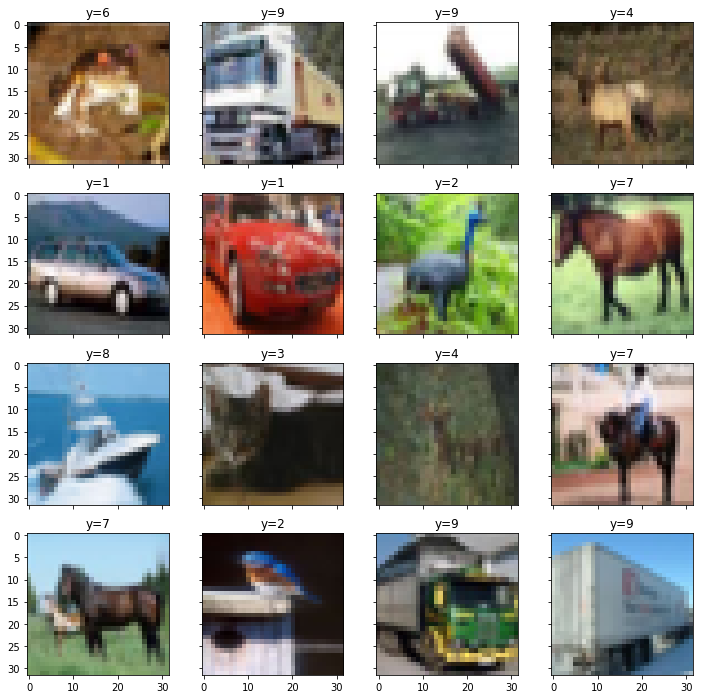

In [10]:
# plot data and labels
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12, 12))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_train[i, :, :], vmin=0, vmax=1)
    ax.set_title('y={}'.format(np.where(y_train[i]==1.)[0][0]))

In [11]:
def conv_layer(num_filters, x, kernel_size=3, strides=1, batch_normalization=True, relu_activation=True):
    x = keras.layers.Conv2D(num_filters, 
                            kernel_size=kernel_size, 
                            padding='same',
                            strides=strides,
                            kernel_regularizer=l2(),
                            #bias_regularizer=l2()
                           )(x)
    if batch_normalization:
        x = keras.layers.BatchNormalization()(x)
    if relu_activation:
        x = keras.layers.Activation('relu')(x)

    return x

In [16]:
def res_block(num_filters, y, kernel_size=3, strides=1, conv_y=True, conv_first=False):
    '''
    if conv_first:
        x = conv_layer(num_filters, y, kernel_size=kernel_size, strides=strides, batch_normalization=True, relu_activation=True)
        x = conv_layer(num_filters, x, kernel_size=kernel_size, strides=1, batch_normalization=True, relu_activation=False)

        y = conv_layer(num_filters, y, kernel_size=1, strides=strides, batch_normalization=False, relu_activation=False)
        
    else:
    '''
    if conv_y:
        x = conv_layer(num_filters, y, kernel_size=kernel_size, strides=strides, batch_normalization=True, relu_activation=True)
        x = conv_layer(num_filters, x, kernel_size=kernel_size, strides=1, batch_normalization=True, relu_activation=False)
        if conv_first:
            y = conv_layer(num_filters, y, kernel_size=1, strides=strides, batch_normalization=False, relu_activation=False)

    else:
        y = conv_layer(num_filters, y, kernel_size=kernel_size, strides=strides, batch_normalization=True, relu_activation=True)
        x = conv_layer(num_filters, y, kernel_size=kernel_size, strides=1, batch_normalization=True, relu_activation=False)

    x = keras.layers.add([y, x])
    x = keras.layers.ReLU()(x)
    return x

In [20]:
def define_model(input_shape, num_classes=10, num_filters = 16, lr=0.0001, dr=0.25,
                 clear_session=True):
    
    if clear_session:
        keras.backend.clear_session()
    
    # input layer
    inputs = keras.layers.Input(shape=input_shape)
    
    # Convolutional layer
    x = conv_layer(num_filters, inputs, kernel_size=3, strides=1, batch_normalization=True, relu_activation=True)
    
    # 32x32x16 -> 16x16x32 --> 8x8x64 residual blocks
    for i in range(3):
        x = res_block(num_filters, x, kernel_size=3, strides=1 if i==0 else 2, conv_y=False if i==0 else True, conv_first=False if i==0 else True)
        x = res_block(num_filters, x, kernel_size=3, strides=1, conv_y=True, conv_first=False)
        x = res_block(num_filters, x, kernel_size=3, strides=1, conv_y=True if i == 0 else False, conv_first=False)
        num_filters *= 2    


    '''
    x = res_block(num_filters, x, kernel_size=3, strides=1, conv_y=False)
    x = res_block(num_filters, x, kernel_size=3, strides=1, conv_y=True)
    x = res_block(num_filters, x, kernel_size=3, strides=1, conv_y=True)
    
    num_filters *= 2    
    x = res_block(num_filters, x, kernel_size=3, strides=2, conv_y=True, conv_first=True)
    x = res_block(num_filters, x, kernel_size=3, strides=1, conv_y=True)
    x = res_block(num_filters, x, kernel_size=3, strides=1, conv_y=False)
    
    num_filters *= 2
    x = res_block(num_filters, x, kernel_size=3, strides=2, conv_y=True, conv_first=True)
    x = res_block(num_filters, x, kernel_size=3, strides=1, conv_y=True)
    x = res_block(num_filters, x, kernel_size=3, strides=1, conv_y=False)
    '''
    # pooling layer, (1, 1, 64)
    x = keras.layers.AveragePooling2D(pool_size=(8, 8)
                                     )(x)

    x = keras.layers.Flatten()(x)

    # dense output layer with softmax activation
    outputs = keras.layers.Dense(num_classes, 
                                 activation='softmax', 
                                 kernel_initializer='he_normal',
                                 kernel_regularizer=l2(),
                                 bias_regularizer=l2())(x)

    # Instantiate model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # optimizer
    opt = keras.optimizers.Adam(lr=lr)

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # return model
    return model

In [21]:
model = define_model(input_shape=x_train.shape[1:], num_classes=num_classes)

# print out info
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# # Define the Keras TensorBoard callback.
# logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# fit data
history = model.fit(x_train, y_train, batch_size=20, epochs=25, 
                   validation_data=(x_val, y_val),
                   shuffle=True,
                   #callbacks=[tensorboard_callback]
                   )

Train on 50000 samples, validate on 5000 samples
Epoch 1/25
46140/50000 [==========================>...] - ETA: 6s - loss: 6.3448 - accuracy: 0.4065

In [ ]:
# %tensorboard --logdir logs

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 12))
axes[0].plot(history.history['loss'], '-o', label='training loss')
axes[0].plot(history.history['val_loss'], '-o', label='validation loss')
axes[0].legend()
axes[1].plot(history.history['accuracy'], '-o', label='training accuracy')
axes[1].plot(history.history['val_accuracy'], '-o', label='validation accuracy')
axes[1].legend()
axes[1].set_xlabel('epochs')

In [ ]:
# run predictions on some test samples
y_pred = model.predict(x_test.astype(float))
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
# compute and plot confusion matrix
cf = tf.math.confusion_matrix(np.where(y_test == 1)[1], 
                              np.argmax(y_pred, axis=-1), 
                              num_classes=num_classes)
cf = np.array(cf)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
fig.suptitle('confusion matrix')
im = ax.matshow(cf)
ax.axis(ax.axis('tight'))
cb = plt.colorbar(im)
cb.set_label('#')
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(i, j, cf[i, j], fontsize=12, color='r', ha='center', va='center')

ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xlabel('predicted labels')
ax.xaxis.set_label_position('top')
ax.set_ylabel('true labels')

In [ ]:
# plot actual vs. predicted labels and their probabilities
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12, 12))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_test[i, :, :], vmin=0, vmax=1)
    ax.set_title('$y=${}, '.format(np.where(y_test[i]==1.)[0][0]) +
                 '$\hat{y}=$' + '{} (p={:.3f})'.format(np.where(y_pred[i]==y_pred[i].max())[0][0], 
                                                       y_pred[i].max()))